In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# Data

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

# Implementation from Scratch

## Initializing Model Parameters

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## Defining L2 Norm Penalty

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) /2

## Defining the Training Loop

In [5]:
def train(lambd):
    w, b = init_params()
    net = lambda X: d2l.linreg(X, w, b)
    loss = d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting 
            # makes `l2_penalty` a vector whose length is `batch_size`.
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

## Training without Regularization

L2 norm of w: 13.23159408569336


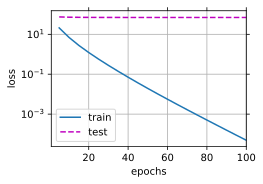

In [6]:
train(lambd=0)

## Using Weight Decay

L2 norm of w: 0.37076279520988464


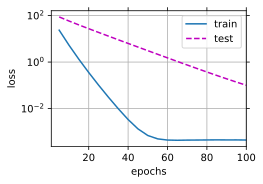

In [7]:
train(lambd=3)

# Concise Implementation 

In [10]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # The bias parameter has no decayed
    trainer = torch.optim.SGD([
        {'params': net[0].weight,
        'weight_decay': wd},
        {'params': net[0].bias}
    ], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 12.513896942138672


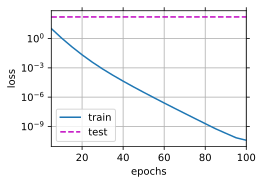

In [11]:
train_concise(0)

L2 norm of w: 0.38637691736221313


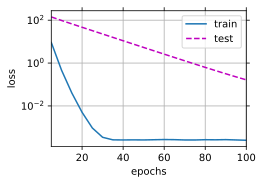

In [12]:
train_concise(3)